[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nxhong93/deep-learning/blob/master/basic.ipynb)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!pip install -q scikit-plot
!pip install -q gensim
import os
import numpy as np
import pandas as pd
import pickle
from gensim import models
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize
import xgboost as xgb
import scikitplot.plotters as skplt

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dropout, LSTM, Activation, Dense

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
train_text = pd.read_csv('drive/My Drive/app/t/nlp/basic/training_text', sep = '\|\|', skiprows=1, header = None, names=['ID', 'Text'])
train_variants = pd.read_csv('drive/My Drive/app/t/nlp/basic/training_variants')
test_text = pd.read_csv('drive/My Drive/app/t/nlp/basic/test_text', sep = '\|\|', skiprows=1, header = None, names=['ID', 'Text'])
test_variants = pd.read_csv('drive/My Drive/app/t/nlp/basic/test_variants')
train = pd.merge(train_variants, train_text, how = 'left', on = 'ID').dropna()
train, _ = train_test_split(train, test_size=0.7, random_state=8)
test = pd.merge(test_variants, test_text, how = 'left', on = 'ID').dropna()
print(train.sample(4))
print(test.sample(4))
print(train['Text'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


        ID    Gene             Variation  Class  \
492    492    TP53                 R248L      1   
98      98  TGFBR2                 D404G      4   
1251  1251  PIK3R1    I559_D560insDKRMNS      4   
3111  3111   RAD21  Truncating Mutations      1   

                                                   Text  
492   Half of all human cancers lose p53 function by...  
98    In many cancers, inactivating mutations in bot...  
1251   ABSTRACT Cancer-specific mutations in the iSH...  
3111  ASXL1 is frequently mutated in a spectrum of m...  
        ID     Gene Variation  \
134    134    SAR1B     S179R   
3739  3739  DYNC2H1    G2461V   
4479  4479     GLB1     R482H   
5050  5050     TSHR     F525L   

                                                   Text  
134   Cell phosphorylates were buffer both S179R for...  
3739  ABSTRACT The retinoblastoma-predisposition gen...  
4479  Hereditary non-polyposis colorectal cancer (HN...  
5050  Recent results from clinical trials with the B... 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [0]:
def evaluate_features(X, y, clf = 'None'):
	clf = LogisticRegression()
	probas = cross_val_predict(clf, X, y, cv = StratifiedKFold(random_state=8), n_jobs = -1, method = 'predict_proba', verbose = -2)
	pred_indices = np.argmax(probas, axis=1)
	class_ = np.unique(y)
	preds = class_[pred_indices]
	print('Log loss: {}'.format(log_loss(y, probas)))
	print('Accuracy: {}'.format(accuracy_score(y, preds)))
	skplt.plot_confusion_matrix(y, preds)

In [0]:
#Bag of word
count_vt = CountVectorizer(tokenizer=word_tokenize, stop_words='english')
bag_of_words = count_vt.fit_transform(train['Text'])

In [0]:
def svd(md):
  svd = TruncatedSVD(n_components=25, n_iter=25, random_state=12)
  truncatedSVD = svd.fit_transform(md)
  return truncatedSVD

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/base.py:340: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.7849945623305377
Accuracy: 0.48993963782696176


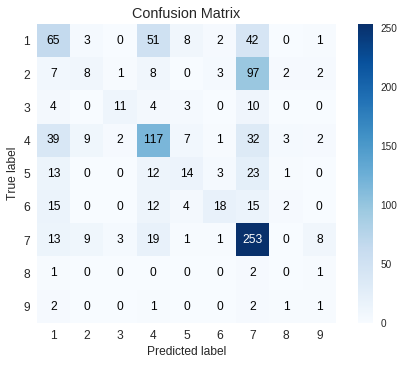

In [14]:
evaluate_features(svd(bag_of_words), train['Class'].values.ravel())

In [15]:
#tf-idf
count_vt_idf = TfidfVectorizer(analyzer='word',tokenizer=word_tokenize, stop_words='english')
tf_idf = count_vt_idf.fit_transform(train['Text'])
print(tf_idf)

  (0, 64929)	0.06780270622094159
  (0, 46614)	0.02753738536686247
  (0, 52520)	0.008090634776842662
  (0, 77485)	0.002884512365340072
  (0, 96127)	0.0029760618870554143
  (0, 149643)	0.0015349106345480899
  (0, 138977)	0.0281265228101446
  (0, 71491)	0.00611542921676636
  (0, 67491)	0.0031141081053701752
  (0, 147644)	0.02339360864050331
  (0, 79746)	0.003248918442688937
  (0, 107630)	0.006078150906485568
  (0, 52359)	0.023222807367561105
  (0, 231)	0.21122872506424933
  (0, 80984)	0.048625207251884545
  (0, 232)	0.21062864345895316
  (0, 1753)	0.38186800264924686
  (0, 114693)	0.016288014246447723
  (0, 85320)	0.013686641086852292
  (0, 57850)	0.013832185520881826
  (0, 60593)	0.09712386697748501
  (0, 99997)	0.10874605821051479
  (0, 128417)	0.04551785728429502
  (0, 99393)	0.010134051900861044
  (0, 85750)	0.009795955942587168
  :	:
  (993, 102605)	0.007444314950421812
  (993, 82698)	0.007444314950421812
  (993, 83824)	0.007444314950421812
  (993, 37446)	0.007256530733031153
  (993,

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.4909573483641962
Accuracy: 0.4778672032193159


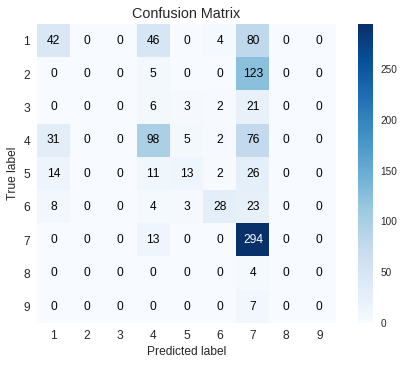

In [16]:
evaluate_features(svd(tf_idf), train['Class'].values.ravel())

In [0]:
#word2vect
class MySentences(object):

    def __init__(self, *arrays):
        self.arrays = arrays
 
    def __iter__(self):
        for array in self.arrays:
            for document in array:
                for sent in sent_tokenize(document):
                    yield word_tokenize(sent)
def Word2Vec(sentences, location):
	if os.path.exists(location):
		module = models.Word2Vec.load(location)
		return module
	module = models.Word2Vec(sentences, workers=4)
	module.save(location)
	return module

In [18]:
w2vmodel = Word2Vec(MySentences(train['Text'].values), 'w2vmodel')
print(w2vmodel['phenocopies'])

[ 0.09950161 -0.22011673 -0.01776122 -0.12178364 -0.34641653  0.22454178
  0.23758711  0.17833732  0.09256488 -0.109923   -0.15627055 -0.01770206
 -0.000973    0.21698543 -0.25988588 -0.0208     -0.2503294  -0.29948035
  0.2522615  -0.24689749  0.03263025  0.19241431  0.0747193   0.10037229
 -0.09149618  0.05318522  0.08793849 -0.18255442 -0.17040437 -0.01518595
  0.02605196  0.07559789  0.4401741   0.15211773 -0.04375574  0.56806266
  0.15292805  0.1078466  -0.19493276 -0.1379175   0.0913616   0.17681132
  0.30609423  0.00441437  0.3348038  -0.0425485   0.08666041  0.4276939
 -0.0663648   0.0209977  -0.12595272 -0.32487786 -0.09264965  0.08237007
 -0.08090966  0.18621232  0.18956965  0.05480384  0.13853645 -0.02237622
  0.2684112  -0.17501216 -0.01138995  0.10147061 -0.00644022  0.13513514
 -0.14873782 -0.21807957 -0.25001407 -0.06335054  0.01438912  0.12460423
  0.02952055  0.16558847 -0.03425865  0.26266032  0.23512523 -0.29590422
  0.03023936  0.01639018 -0.07223921  0.04404847  0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
word2vec = models.Word2Vec.load('w2vmodel')
def Mytokenizer(X):
	transform_array = []
	for document in X:
		transform_doc = []
		for sent in sent_tokenize(document):
			transform_doc += word_tokenize(sent)
		transform_array.append(np.array(transform_doc))
	return transform_array


class EmbeddingVectoizer(object):
	def __init__(self, word2vec):
		self.word2vec = word2vec
		self.dim = len(word2vec.wv.syn0[0])
	def fit(self, X, y=None):
		return self
	def transform(self, X):
		x = Mytokenizer(X)
		return np.array([np.mean([self.word2vec.wv[w] for w in words if w in word2vec.wv] or [np.zeros(self.dim)], axis=0) for words in x])
	def fit_transform(self, X, y=None):
		return self.transform(X)

In [20]:
em_vt = EmbeddingVectoizer(w2vmodel)
mean_em = em_vt.fit_transform(train['Text'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  from ipykernel import kernelapp as app


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


Log loss: 1.3690400888103451
Accuracy: 0.5110663983903421


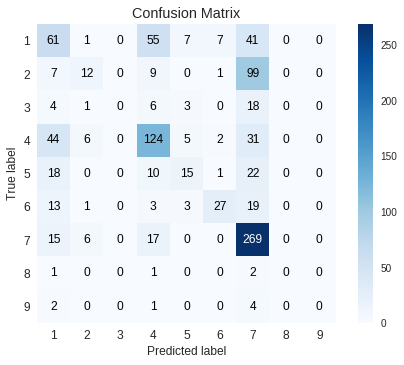

In [21]:
evaluate_features(svd(mean_em), train['Class'].values.ravel())

In [0]:
#Tokenizer
num_word = 2000
tokenizer = Tokenizer(num_words=num_word)
tokenizer.fit_on_texts(train['Text'].values)

In [23]:
#Pad to sequences
X = tokenizer.texts_to_sequences(train['Text'].values)
X = pad_sequences(X, maxlen=num_word)
print(X)
print(X.shape)

[[  23    6 1195 ...  923    4  101]
 [ 102    6  949 ...  131    2   38]
 [ 222   25    6 ...   70 1950    3]
 ...
 [   8  878  120 ...   12  709  229]
 [1311    3   22 ...   11    4    1]
 [  85   24  107 ...    4   50  947]]
(994, 2000)


In [24]:
#Build simple LSTM
batch_size = 32
epoch = 8
em_dim = 128
LSTM_out = 196
ckpt_callback = ModelCheckpoint('keras_model', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
model = Sequential()
model.add(Embedding(num_word, em_dim, input_length=X.shape[1]))
model.add(LSTM(LSTM_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 128)         256000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1773      
Total params: 512,573
Trainable params: 512,573
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
Y = pd.get_dummies(train['Class'].values)
print(Y)

     1  2  3  4  5  6  7  8  9
0    0  0  0  1  0  0  0  0  0
1    0  0  0  0  1  0  0  0  0
2    0  0  0  0  0  1  0  0  0
3    0  1  0  0  0  0  0  0  0
4    0  0  0  1  0  0  0  0  0
5    1  0  0  0  0  0  0  0  0
6    0  0  0  0  0  0  1  0  0
7    0  0  0  1  0  0  0  0  0
8    1  0  0  0  0  0  0  0  0
9    0  0  0  0  0  1  0  0  0
10   0  0  0  1  0  0  0  0  0
11   1  0  0  0  0  0  0  0  0
12   0  0  0  0  0  0  1  0  0
13   0  0  0  0  0  0  1  0  0
14   0  0  0  1  0  0  0  0  0
15   0  0  0  0  0  0  1  0  0
16   1  0  0  0  0  0  0  0  0
17   0  0  0  0  0  0  1  0  0
18   0  0  0  0  1  0  0  0  0
19   0  0  0  1  0  0  0  0  0
20   0  0  0  0  0  0  1  0  0
21   0  0  0  0  1  0  0  0  0
22   0  1  0  0  0  0  0  0  0
23   0  0  0  0  0  1  0  0  0
24   0  1  0  0  0  0  0  0  0
25   0  1  0  0  0  0  0  0  0
26   0  0  0  1  0  0  0  0  0
27   0  0  0  0  0  1  0  0  0
28   0  0  0  0  0  0  1  0  0
29   0  0  0  1  0  0  0  0  0
..  .. .. .. .. .. .. .. .. ..
964  0  

In [36]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)
y_test = np.array(y_test)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(795, 2000)
(199, 2000)
(795, 9)
(199, 9)


In [27]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epoch, validation_split=0.2, callbacks=[ckpt_callback])

Train on 636 samples, validate on 159 samples
Epoch 1/8
636/636 [==============================] - 149s 234ms/step - loss: 2.0294 - acc: 0.2893 - val_loss: 1.8115 - val_acc: 0.2893

Epoch 00001: val_loss improved from inf to 1.81148, saving model to keras_model
Epoch 2/8
636/636 [==============================] - 146s 230ms/step - loss: 1.7926 - acc: 0.3129 - val_loss: 1.7799 - val_acc: 0.3711

Epoch 00002: val_loss improved from 1.81148 to 1.77989, saving model to keras_model
Epoch 3/8
636/636 [==============================] - 150s 235ms/step - loss: 1.7235 - acc: 0.3711 - val_loss: 1.7160 - val_acc: 0.3585

Epoch 00003: val_loss improved from 1.77989 to 1.71601, saving model to keras_model
Epoch 4/8
636/636 [==============================] - 150s 235ms/step - loss: 1.5715 - acc: 0.4717 - val_loss: 1.5970 - val_acc: 0.4340

Epoch 00004: val_loss improved from 1.71601 to 1.59700, saving model to keras_model
Epoch 5/8
636/636 [==============================] - 153s 240ms/step - loss: 1

In [37]:
model = load_model('keras_model')
print(model.predict(x_test))
print(np.array(y_test))
print(np.argmax(np.array(y_test), axis=1))


[[0.17103723 0.17514233 0.03082744 ... 0.33322498 0.01150295 0.01273485]
 [0.30144653 0.10112524 0.03893147 ... 0.0621412  0.01212405 0.01451219]
 [0.01422569 0.13744599 0.00545746 ... 0.7914884  0.00128702 0.00178508]
 ...
 [0.33718345 0.09387216 0.02996031 ... 0.12478397 0.00975694 0.01118811]
 [0.04183035 0.29844823 0.05521154 ... 0.3275271  0.02768631 0.03206917]
 [0.19490081 0.13047327 0.04239003 ... 0.08768903 0.01184047 0.014299  ]]
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]]
[0 4 6 3 1 6 0 6 5 6 0 6 6 3 0 3 1 5 6 0 2 3 0 3 0 3 5 6 3 6 4 4 4 3 6 6 3
 1 1 0 4 1 3 6 1 3 0 3 0 1 1 1 1 5 0 6 4 4 6 6 0 3 6 0 3 0 8 5 3 5 6 6 6 6
 6 1 3 1 0 3 5 6 1 0 6 6 5 3 0 4 3 6 0 0 6 5 2 7 4 0 1 3 0 2 0 0 6 3 1 6 6
 6 6 3 0 0 0 1 3 6 6 0 6 6 4 5 1 3 3 1 1 6 6 3 3 6 1 6 3 6 5 2 3 3 6 3 6 3
 6 3 6 1 1 4 6 6 6 6 3 2 3 6 1 3 6 6 1 0 4 6 6 3 0 0 6 0 1 6 6 2 3 0 6 3 3
 0 4 6 3 0 5 6 3 6 1 3 5 6 6]


In [0]:
def evaluate_features_LSTM(x_test, y_test):
	probas = model.predict(x_test)
	pred_indices = np.argmax(probas, axis=1)
	class_ = np.array(range(1,10))
	preds = class_[pred_indices]
	y_pre_max = np.argmax(y_test, axis=1)
	print('Log loss: {}'.format(log_loss(y_pre_max, probas)))
	print('Accuracy: {}'.format(accuracy_score(y_pre_max, preds)))
	skplt.plot_confusion_matrix(y_pre_max, preds)


Log loss: 1.5096030982220592
Accuracy: 0.02512562814070352


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)


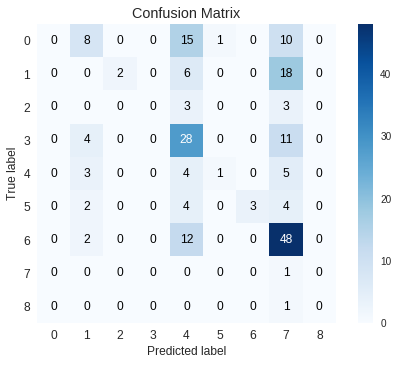

In [39]:
evaluate_features_LSTM(x_test, y_test)